In [2]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import boto3
import sagemaker
import tarfile
import joblib
import sklearn
import mlflow.pyfunc

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import linear_model, tree
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from sagemaker.serializers import CSVSerializer
from sagemaker.model import Model
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from time import gmtime, strftime
from scipy.stats import ks_2samp

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, RegressionPreset
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab

sagemaker.config INFO - Not applying SDK defaults from location: /opt/homebrew/share/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/darian/Library/Application Support/sagemaker/config.yaml


/opt/homebrew/lib/python3.8/site-packages/evidently/analyzers/__init__.py:3: UserWarning: analyzers are deprecated, use metrics instead
  warnings.warn("analyzers are deprecated, use metrics instead")
/opt/homebrew/lib/python3.8/site-packages/evidently/dashboard/__init__.py:8: UserWarning: dashboards are deprecated, use metrics instead
  warnings.warn("dashboards are deprecated, use metrics instead")


### EDA & Feature Engineering

Data columns after label encoding:
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')


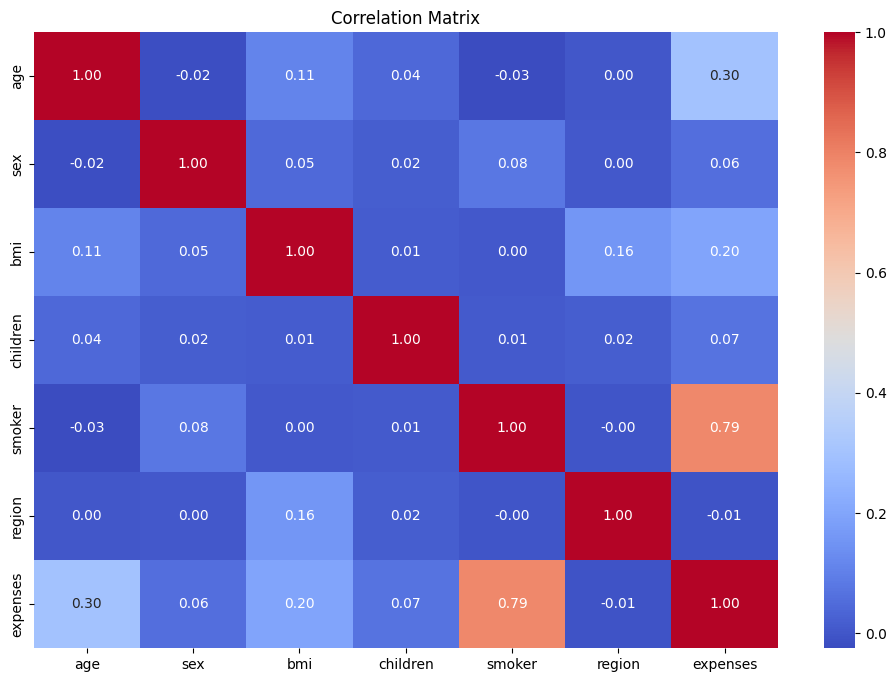

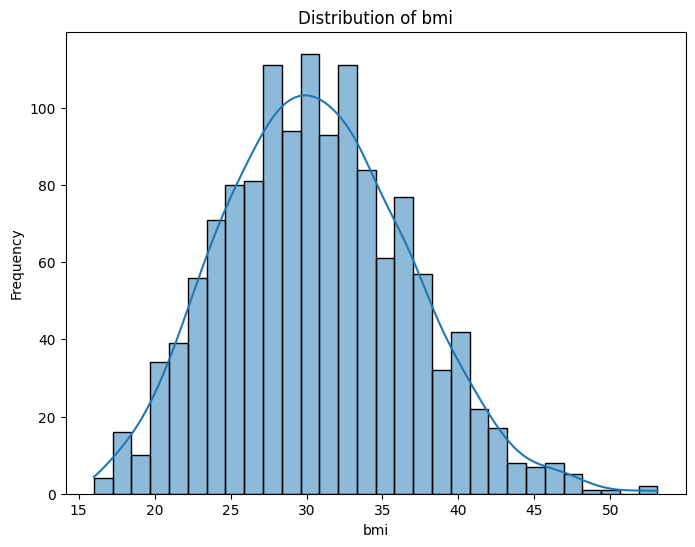

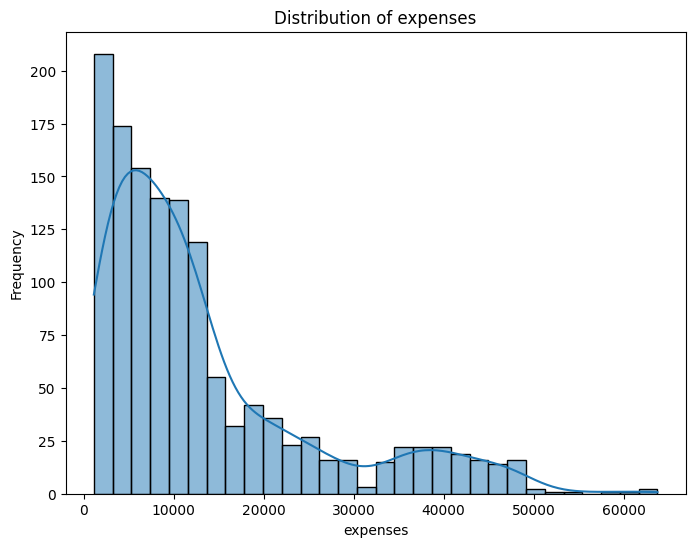

               age          sex          bmi     children       smoker  \
count  1338.000000  1338.000000  1338.000000  1338.000000  1338.000000   
mean     39.207025     0.505232    30.665471     1.094918     0.204783   
std      14.049960     0.500160     6.098382     1.205493     0.403694   
min      18.000000     0.000000    16.000000     0.000000     0.000000   
25%      27.000000     0.000000    26.300000     0.000000     0.000000   
50%      39.000000     1.000000    30.400000     1.000000     0.000000   
75%      51.000000     1.000000    34.700000     2.000000     0.000000   
max      64.000000     1.000000    53.100000     5.000000     1.000000   

            region      expenses  
count  1338.000000   1338.000000  
mean      1.515695  13270.422414  
std       1.104885  12110.011240  
min       0.000000   1121.870000  
25%       1.000000   4740.287500  
50%       2.000000   9382.030000  
75%       2.000000  16639.915000  
max       3.000000  63770.430000  


In [3]:

# Load data
data = pd.read_csv('../data/health-insurance.csv')

# Identify categorical and numerical features
categorical_features = ['sex', 'region', 'smoker']
numerical_features = ['age', 'bmi', 'children', 'expenses']
distribution_plots = ['bmi', 'expenses']

# Label Encoding for binary categorical features
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])

# Print the columns to check if encoding was successful
print("Data columns after label encoding:")
print(data.columns)

# Convert the encoded columns to int64
data['sex'] = data['sex'].astype('int64')
data['smoker'] = data['smoker'].astype('int64')

# Label Encoding for ordinal relationship in 'region'
data['region'] = label_encoder.fit_transform(data['region'])

# Visualize correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plot histograms for numerical features
for feature in distribution_plots:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Print descriptive statistics
print(data.describe())

# Save the encoded dataframe to a new CSV file
encoded_df = pd.DataFrame(data)
# encoded_df.to_csv('../data/encoded-data.csv', index=False)

### Divide dataset and upload to S3 bucket

In [4]:
X = encoded_df.drop(columns=['expenses'])
y = encoded_df['expenses']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate the features and target variable for train and validation sets
train = pd.concat([X_train, y_train], axis=1)
validation = pd.concat([X_test, y_test], axis=1)

print(validation)

# Ensure the data directory exists
data_dir = '../data'
os.makedirs(data_dir, exist_ok=True)

# Save the train and validation data to CSV files
train.to_csv(os.path.join(data_dir, 'train.csv'), index=False)
validation.to_csv(os.path.join(data_dir, 'validation.csv'), index=False)

# Verify the contents of the CSV files
print("Train data:")
print(train.head())
print("Validation data:")
print(validation.head())

# Fetch AWS credentials
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
aws_region = 'eu-north-1'

# Initialize a session using Amazon S3
s3 = boto3.client('s3', region_name=aws_region, aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)
bucket_name = 'health-ins-bucket'

# Upload the train and validation CSV files to S3
# s3.upload_file(os.path.join(data_dir, 'train.csv'), bucket_name, 'data/train.csv')
# s3.upload_file(os.path.join(data_dir, 'validation.csv'), bucket_name, 'data/validation.csv')

print("Files uploaded successfully to S3")

      age  sex   bmi  children  smoker  region  expenses
764    45    0  25.2         2       0       0   9095.07
887    36    0  30.0         0       0       1   5272.18
890    64    0  26.9         0       1       1  29330.98
1293   46    1  25.7         3       0       1   9301.89
259    19    1  31.9         0       1       1  33750.29
...   ...  ...   ...       ...     ...     ...       ...
109    63    1  35.1         0       1       2  47055.53
575    58    0  27.2         0       0       1  12222.90
535    38    1  28.0         1       0       0   6067.13
543    54    0  47.4         0       1       2  63770.43
846    51    0  34.2         1       0       3   9872.70

[268 rows x 7 columns]
Train data:
      age  sex   bmi  children  smoker  region  expenses
560    46    0  20.0         2       0       1   9193.84
1285   47    0  24.3         0       0       0   8534.67
1142   52    0  24.9         0       0       2  27117.99
969    39    0  34.3         5       0       2   859

### Model development and tuning

RMSE: 4349.232989092396
R^2: 0.8781579267070162
Explained Variance Score: 0.8786207586181467
MAPE: 0.27917579211813826


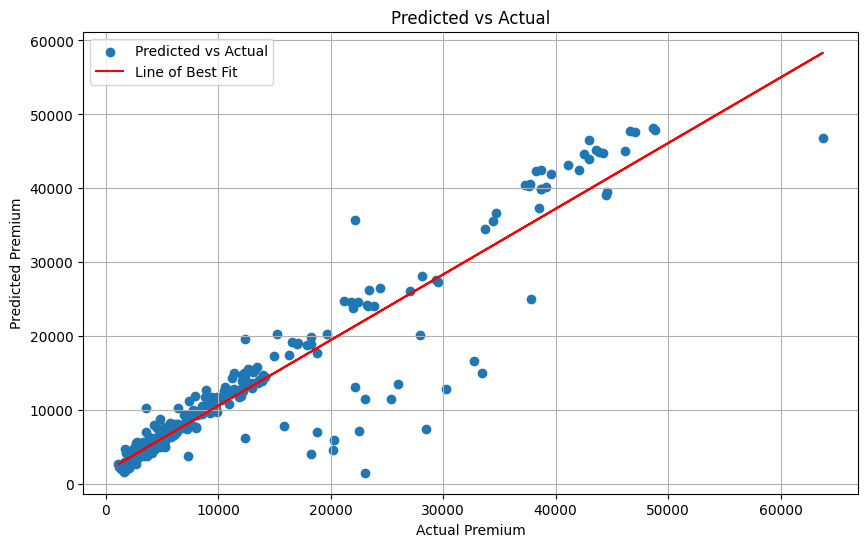

Model successfully loaded and evaluated


In [5]:
# Load the data
data = pd.read_csv('../data/encoded-data.csv')

# Split the data into features and target
X = data.drop(columns=['expenses'])
y = data['expenses']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(
    n_estimators=600,
    min_samples_split=10,
    min_samples_leaf=4
)
model.fit(X_train, y_train)

# Save the model as a .pkl file
# model_filename = '../models/optimal-model-rfr.pkl'
# joblib.dump(model, model_filename)

# mlflow.set_tracking_uri("http://localhost:5002")
# model_name = "RFR-health-ins"
# model_stage_or_version = "latest"

# model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_stage_or_version}")


# Predictions and evaluation
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
evs = explained_variance_score(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'Explained Variance Score: {evs}')
print(f'MAPE: {mape}')

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred, label='Predicted vs Actual')
m, b = np.polyfit(y_test, pred, 1)
plt.plot(y_test, m * y_test + b, color='red', label='Line of Best Fit')

plt.xlabel('Actual Premium')
plt.ylabel('Predicted Premium')
plt.title('Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

print("Model successfully loaded and evaluated")

### Create executable file for deployment

In [6]:
%%writefile script.py

import argparse
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split, cross_val_score
from joblib import dump, load
import io

# Functions required for SageMaker
def model_fn(model_dir):
    """Load model from the model_dir."""
    model = load(os.path.join(model_dir, "model.joblib"))
    return model

def input_fn(input_data, content_type):
    """Deserialize the input data."""
    if content_type == "text/csv":
        return pd.read_csv(io.StringIO(input_data), header=None)
    else:
        raise ValueError("Unsupported content type: {}".format(content_type))

def predict_fn(input_data, model):
    """Make predictions using the model."""
    return model.predict(input_data)

def output_fn(prediction, content_type):
    """Serialize the output data."""
    if content_type == "text/csv":
        return ",".join(map(str, prediction))
    else:
        raise ValueError("Unsupported content type: {}".format(content_type))

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_estimators", type=int, default=600)
    parser.add_argument("--min_samples_split", type=int, default=10)
    parser.add_argument("--min_samples_leaf", type=int, default=4)
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    args = parser.parse_args()
    
    # Load the datasets
    train_df = pd.read_csv(os.path.join(args.train, "train.csv"))
    validation_df = pd.read_csv(os.path.join(args.validation, "validation.csv"))
    
    # Split features and target
    X_train = train_df.drop(columns=['expenses'])
    y_train = train_df['expenses']
    X_validation = validation_df.drop(columns=['expenses'])
    y_validation = validation_df['expenses']
    
    # Initialize and train the model
    model = RandomForestRegressor(
        n_estimators=args.n_estimators,
        min_samples_split=args.min_samples_split,
        min_samples_leaf=args.min_samples_leaf
    )
    model.fit(X_train, y_train)
    
    # Save the model
    model_dir = os.environ.get("SM_MODEL_DIR")
    dump(model, os.path.join(model_dir, "model.joblib"))
    
    # Predictions and evaluation
    pred = model.predict(X_validation)
    rmse = np.sqrt(mean_squared_error(y_validation, pred))
    r2 = r2_score(y_validation, pred)
    evs = explained_variance_score(y_validation, pred)
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    print(f'Explained Variance Score: {evs}')
    
    # Cross-validation performance metrics
    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_evs = cross_val_score(model, X_train, y_train, cv=5, scoring='explained_variance')
    
    print('Cross-Validation Performance metrics')
    print(f'CV RMSE: {cv_rmse.mean()}')
    print(f'CV R^2: {cv_r2.mean()}')
    print(f'CV Explained Variance Score: {cv_evs.mean()}')

Overwriting script.py


### Deployment

In [7]:
# import sagemaker
# from sagemaker.sklearn.estimator import SKLearn

# FRAMEWORK_VERSION = "0.23-1"

# sagemaker_session = sagemaker.Session()

# sklearn_estimator = SKLearn(
#     entry_point="script.py",
#     role="arn:aws:iam::014498627053:role/sagemaker-eks-deployment",
#     instance_count=1,
#     instance_type="ml.m5.large",
#     framework_version=FRAMEWORK_VERSION,
#     base_job_name="rfr-sklearn",
#     hyperparameters={
#         "n_estimators": 600,
#         "min_samples_split": 10,
#         "min_samples_leaf": 4
#     }
# )

# train_path = 's3://health-ins-bucket/data/train.csv'
# validation_path = 's3://health-ins-bucket/data/validation.csv'

# sklearn_estimator.fit({"train": train_path, "validation": validation_path}, wait=True)

In [8]:
# # Create a SageMaker client
# sagemaker_client = boto3.client('sagemaker')

# # Describe the training job to get the model artifacts
# response = sagemaker_client.describe_training_job(
#     TrainingJobName=sklearn_estimator.latest_training_job.name
# )

# artifact = response["ModelArtifacts"]["S3ModelArtifacts"]

# print("Model artifact persisted at " + artifact)

In [9]:
# # AWS endpoint deployment

# sklearn_estimator = SKLearn.attach(training_job_name="rfr-sklearn-2024-08-03-09-42-50-995")

# endpoint_name = "custom-RFR-model-deploy-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
# print("EndpointName={}".format(endpoint_name))

# predictor = sklearn_estimator.deploy(
#     initial_instance_count=1,
#     instance_type="ml.m5.large",
#     endpoint_name=endpoint_name,
# )

In [10]:
# # Cleanup - to avoid charges

# sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

# """
# CLEANUP ON AWS UI:
# Inference -> Endpoints -> Actions -> Delete.
# Inference -> Endpoint configurations -> Actions -> Delete.
# Inference -> Models -> Actions -> Delete.
# Notebook -> Notebook Instances -> Actions -> Stop (Wait) -> Actions -> Delete.
# """

### Inferencing

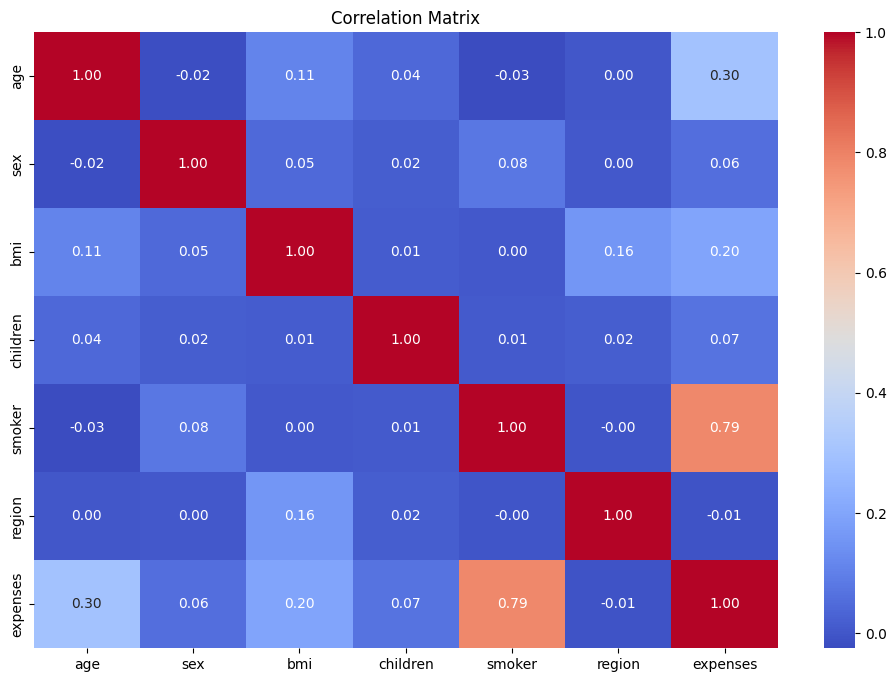

               age          sex          bmi     children       smoker  \
count  1338.000000  1338.000000  1338.000000  1338.000000  1338.000000   
mean     39.207025     0.505232    30.663397     1.094918     0.204783   
std      14.049960     0.500160     6.098187     1.205493     0.403694   
min      18.000000     0.000000    15.960000     0.000000     0.000000   
25%      27.000000     0.000000    26.296250     0.000000     0.000000   
50%      39.000000     1.000000    30.400000     1.000000     0.000000   
75%      51.000000     1.000000    34.693750     2.000000     0.000000   
max      64.000000     1.000000    53.130000     5.000000     1.000000   

            region      expenses  
count  1338.000000   1338.000000  
mean      1.515695  13270.422265  
std       1.104885  12110.011237  
min       0.000000   1121.873900  
25%       1.000000   4740.287150  
50%       2.000000   9382.033000  
75%       2.000000  16639.912515  
max       3.000000  63770.428010  


In [11]:
# Load raw inference data
inf_subset = pd.read_csv('../data/raw-inf-data.csv')
inf_dropped = inf_subset.drop(columns=['steps', 'insuranceclaim'])
inf = inf_dropped.rename(columns={'charges': 'expenses'})
inf.head()

inf.to_csv('../data/encoded-inf-data.csv', index=False)

# Visualize correlation matrix
correlation_matrix = inf.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print(inf.describe())



In [12]:

# Split the data into features and target
X = inf.drop(columns=['expenses'])
y = inf['expenses']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(
    n_estimators=600,
    min_samples_split=10,
    min_samples_leaf=4
)
model.fit(X_train, y_train)

# Predictions and evaluation
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
evs = explained_variance_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'Explained Variance Score: {evs}')

# Cross-validation performance metrics
cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
cv_evs = cross_val_score(model, X_train, y_train, cv=5, scoring='explained_variance')

print('Cross-Validation Performance metrics')
print(f'CV RMSE: {cv_rmse.mean()}')
print(f'CV R^2: {cv_r2.mean()}')
print(f'CV Explained Variance Score: {cv_evs.mean()}')

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred, label='Predicted vs Actual')
m, b = np.polyfit(y_test, pred, 1)
plt.plot(y_test, m * y_test + b, color='red', label='Line of Best Fit')

plt.xlabel('Actual Premium')
plt.ylabel('Predicted Premium')
plt.title(f'{model.__class__.__name__}: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

print("Model successfully applied onto inference data")

RMSE: 4338.730657893491
R^2: 0.8787456519556658
Explained Variance Score: 0.8792358202226058


### Monitoring

#### Model drift

In [ ]:
target = 'expenses'
prediction = 'prediction'
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'region', 'smoker']

inf.head()

In [ ]:
reference = inf[:600]
current = inf[350:]

regressor = RandomForestRegressor(
    n_estimators=600,
    min_samples_split=10,
    min_samples_leaf=4
)

regressor.fit(reference[numerical_features + categorical_features], reference[target])

In [ ]:
ref_prediction = regressor.predict(reference[numerical_features + categorical_features])
current_prediction = regressor.predict(current[numerical_features + categorical_features])
new_prediction = regressor.predict(current[numerical_features + categorical_features])

reference['prediction'] = ref_prediction
current['prediction'] = current_prediction


column_mapping = ColumnMapping()

column_mapping.target = target
column_mapping.prediction = prediction
column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features

regression_perfomance = Report(metrics=[RegressionPreset()])
regression_perfomance.run(current_data=reference, reference_data=None, column_mapping=column_mapping)

regression_perfomance.show()



In [ ]:
## Save reports
regression_perfomance.save('../reports/temp.html')

In [ ]:
column_mapping = ColumnMapping()

column_mapping.numerical_features = numerical_features

In [ ]:
#data_drift.save("reports/data_drift_dashboard_after_week1.html")

#### Data drift

In [ ]:
target = 'expenses'
prediction = 'prediction'
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'region', 'smoker']

inf.head()

In [ ]:
data_drift_dashboard = Dashboard(tabs=[DataDriftTab()])
data_drift_dashboard.calculate(inf[:200], inf[200:])

data_drift_dashboard.show(mode='inline')

In [ ]:
# data_drift_dashboard.save('../reports/DataDrift.html')